In [36]:
%%capture --no-stderr
%pip install --quiet -U langgraph


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## State Definition

In [37]:
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator
from langgraph.graph import MessagesState

# State 정의
class GraphState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    # Which means the below is pre-defined and built-in
    # messages: Annotated[List[BaseMessage], operator.add]
    context: Annotated[List[Document], operator.add]
    answer: Annotated[List[Document], operator.add]
    question: Annotated[str, "user question"]
    sql_query: Annotated[str, "sql query"]
    binary_score: Annotated[str, "1 or 0"]

## Node Definition

#### - Define nodes with functions; later, we can do the same using classes.

In [38]:
def retrieve(state: GraphState) -> GraphState:
    # Search and retrieve documents
    documents = "My Searched Documents"
    print("retrieve func call")
    # return GraphState(context=documents) # This is explicitly clearer.
    return {"context":[documents]} # Same as above

def rewrite_query(state: GraphState) -> GraphState:
    # rewrite the query
    documents = "My Searched Documents"
    print("rewrite_query func call")
    return GraphState(context=[documents])

def llm_gpt_execute(state: GraphState) -> GraphState:
    # execute LLM
    answer = "Answer generated from GPT"
    print("llm_gpt_execute func call")
    return GraphState(answer=[answer])
    
def llm_claude_execute(state: GraphState) -> GraphState:
    # execute LLM
    answer = "Answer generated from Claude"
    print("llm_claude_execute func call")
    return GraphState(answer=[answer])

def relevance_check(state: GraphState) -> GraphState:
    # Check for relevance
    binary_score = "1"
    # binary_score = "0"
    print("relevance_check func call")
    return GraphState(binary_score=binary_score)

def sum_up(state: GraphState) -> GraphState:
    # Conclusive summary
    answer = "Conclusive summary"
    print("sum_up func call")
    return GraphState(answer=[answer])

def search_on_web(state: GraphState) -> GraphState:
    # Search on web
    documents = state["context"] = "existing documents"
    searched_documents = "new documents"
    documents += searched_documents
    print("search_on_web func call")
    return GraphState(context=[documents])

def get_table_info(state: GraphState) -> GraphState:
    # Get Table metadata
    table_info = "Table info"
    print("get_table_info func call")
    return GraphState(context=[table_info])

def generate_sql_query(state: GraphState) -> GraphState:
    # generate sql query
    sql_query = "sql query"
    print("generate_sql_query func call")
    return GraphState(sql_query=sql_query)

def execute_sql_query(state: GraphState) -> GraphState:
    # execute sql query
    sql_result = "sql result"
    print("execute_sql_query func call")
    return GraphState(context=sql_result)

def validate_sql_query(state: GraphState) -> GraphState:
    # validate sql query
    binary_score = "validation result"
    print("validate_sql_query func call")
    return GraphState(binary_score=binary_score)

def handle_error(state:GraphState) -> GraphState:
    # Handle errors
    error = "error contents"
    print("handle_error func call")
    return GraphState(context=error)

def decision(state: GraphState) -> GraphState:
    # make decisions
    decision = "decision"
    print("decision func call")

    if state["binary_score"] == "1":
        return "END"
    else:
        return "re-search"
    return decision

## Graph definition

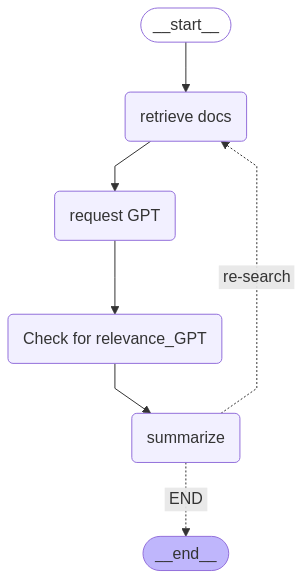

In [43]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

# (1) Conventional RAG
# (2) re-search
# (3) Multi-LLM
# (4) re-write query

# Add nodes
workflow = StateGraph(GraphState)
workflow.add_node("retrieve docs", retrieve)
# workflow.add_node("rewrite query", rewrite_query) # (4)
workflow.add_node("request GPT", llm_gpt_execute)
# workflow.add_node("request Claude", llm_clude_execute) # (3)
workflow.add_node("Check for relevance_GPT", relevance_check)
# workflow.add_node("Check for relevance_Claude", relevance_check) # (3)
workflow.add_node("summarize", sum_up)

# Add edges

workflow.add_edge("retrieve docs", "request GPT")
# workflow.add_edge("retrieve docs", "request Claude") # (3)
# workflow.add_edge("rewrite query", "retrieve docs") # (4)
workflow.add_edge("request GPT", "Check for relevance_GPT")
workflow.add_edge("Check for relevance_GPT", "summarize")
# workflow.add_edge("request Claude", "Check for relevance_Claude") # (3)
# workflow.add_edge("Check for relevance_Claude", "summarize") # (3)
# workflow.add_edge("summarize", END) # (2) - off

# Add contitional Edges
workflow.add_conditional_edges(
    "summarize",
    decision,
    {
        "re-search": "retrieve docs", # if the summary is not relevant to the user prompt, search docs again
        "END": END # if the summary is relevant to the user prompt, END
    },
)

# Set the starting node
workflow.set_entry_point("retrieve docs")

# Set memory
memory = MemorySaver()

# Compile the workflow
app = workflow.compile(checkpointer=memory)

# Visualize the result
display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
mermaid_code = app.get_graph().draw_mermaid()
print(mermaid_code)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	retrieve_docs(retrieve docs)
	request_GPT(request GPT)
	Check_for_relevance_GPT(Check for relevance_GPT)
	summarize(summarize)
	__end__([<p>__end__</p>]):::last
	Check_for_relevance_GPT --> summarize;
	__start__ --> retrieve_docs;
	request_GPT --> Check_for_relevance_GPT;
	retrieve_docs --> request_GPT;
	summarize -. &nbsp;END&nbsp; .-> __end__;
	summarize -. &nbsp;re-search&nbsp; .-> retrieve_docs;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [41]:
from langchain_core.messages import AIMessage, HumanMessage
config={
        "configurable": {
            "thread_id": "test-thread-123",
        }
    }
messages = app.invoke(
    {"messages": [HumanMessage(content="Hello LangGraph")]},
    config=config
)
for m in messages['messages']:
    m.pretty_print()

retrieve func call
llm_gpt_execute func call
relevance_check func call
sum_up func call
decision func call
================================ Human Message =================================

Hello LangGraph
